### GoogleNet

#### Inception module
1×1、3×3、5×5の畳み込み層、そして3×3のMaxPooling層のそれぞれの出力を結合して1つの出力とします。

#### dimension reduction
3×3、5×5の畳み込み層の前にチャンネル数を削減するために1×1の畳み込み層を追加します。
さらにMaxPooling層の後にも1×1の畳み込み層を入れることでチャンネル数を変換します。

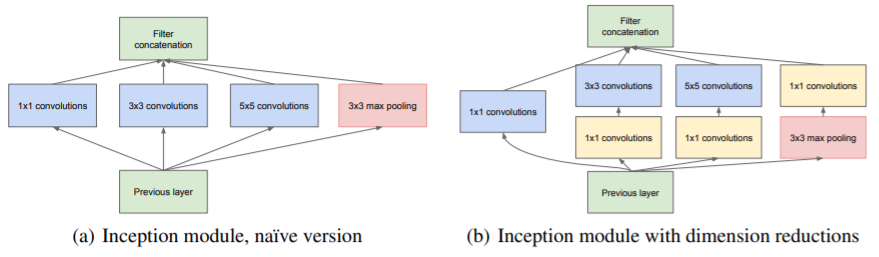

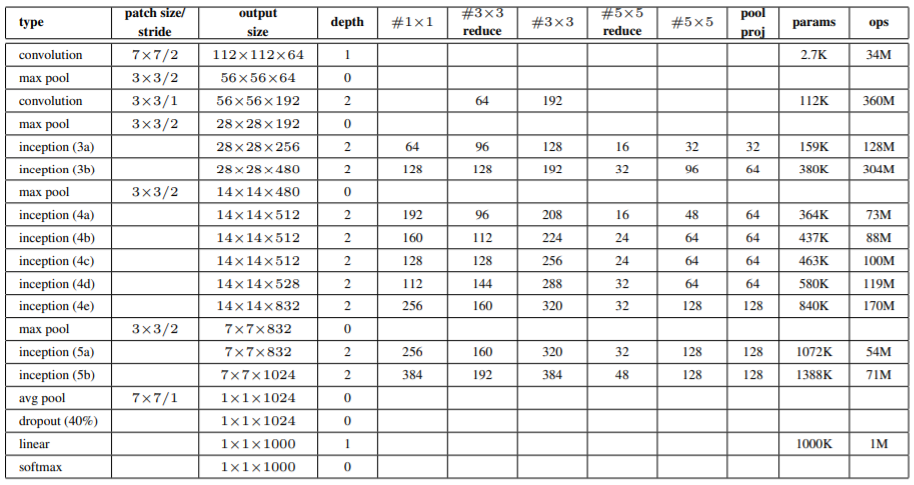

#### auxiliary classifier
最後の出力層とは別にinception module4aと4dからの出力を使用した分類器を用意します。  
3つの出力に重みをつけて足し合わせて学習で使用する損失とします。  
重みは最後の出力層は1、中間層からの2つは0.3とします。  
推論時にはこれらの中間層からの予測結果は出さないようにします。

In [1]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Add
from keras.layers.merge import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
import numpy as np
import cv2

In [90]:
class conv_bn_relu(Model):
    def __init__(self, out_channels, kernel_size=1, strides=1):
        super(conv_bn_relu, self).__init__()
        self.conv = Conv2D(out_channels, kernel_size=kernel_size, strides=strides, padding='same')
        self.bn = BatchNormalization()
        self.relu = Activation("relu")

    def call(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x

In [91]:
class InceptionAux(Model):
    def __init__(self, num_classes):
        super(InceptionAux, self).__init__()
        self.pool = AveragePooling2D(pool_size = (5,5), strides = 3)
        self.conv = conv_bn_relu(out_channels=128, kernel_size=1, strides=1)
        self.flat = Flatten()
        self.fc1 =Dense(1024, activation = 'relu')
        self.fc2 = Dense(10, activation = 'softmax')
        self.dropout = Dropout(0.7)

    def call(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.flat(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)  

        return x

In [92]:
model = InceptionAux(num_classes=10)
model.build((None, 14, 14, 3))  # build with input shape.
dummy_input = Input(shape=(14, 14, 3))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input))
model_summary.summary()

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 14, 14, 3)]       0         
_________________________________________________________________
average_pooling2d_13 (Averag (None, 4, 4, 3)           0         
_________________________________________________________________
conv_bn_relu_657 (conv_bn_re (None, 4, 4, 128)         1024      
_________________________________________________________________
flatten_13 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_21 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 10)              

In [19]:
class Inception(Model):
    def __init__(self, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        self.brabch1 = conv_bn_relu(out_channels=ch1x1, kernel_size=1, strides=1)
        self.branch2 = Sequential([conv_bn_relu(out_channels=ch3x3red, kernel_size=1, strides=1),
                                   conv_bn_relu(out_channels=ch3x3, kernel_size=3, strides=1)])
        self.branch3 = Sequential([conv_bn_relu(out_channels=ch5x5red, kernel_size=1, strides=1),
                                   conv_bn_relu(out_channels=ch5x5, kernel_size=5, strides=1)])
        self.branch4 = Sequential([MaxPooling2D(pool_size=3, strides=1, padding='same'),
                                   conv_bn_relu(out_channels=pool_proj, kernel_size=1, strides=1)])

    def call(self, x):
        brabch1 = self.brabch1(x)
        brabch2 = self.branch2(x)
        brabch3 = self.branch3(x)
        brabch4 = self.branch4(x)
        
        out = concatenate([brabch1, brabch2, brabch3, brabch4], axis = -1)
        return out

In [55]:
class GoogleNet(Model):
    def __init__(self, aux=True):
        super(GoogleNet, self).__init__()
        self.aux = aux
        
        self.conv1 = conv_bn_relu(out_channels=64, kernel_size=7, strides=2)
        self.pool1 = MaxPooling2D(pool_size=3, strides=2, padding='same')
        self.conv2 = conv_bn_relu(out_channels=64, kernel_size=3, strides=1)
        self.conv3 = conv_bn_relu(out_channels=192, kernel_size=3, strides=1)
        self.pool2 = MaxPooling2D(pool_size=3, strides=2, padding='same')
        
        self.inception_3a = Inception(64, 96, 128, 16, 32, 32)
        self.inception_3b = Inception(128, 128, 192, 32, 96, 64)
        self.pool3 = MaxPooling2D(pool_size=3, strides=2, padding='same')
        
        self.inception_4a = Inception(192, 96, 208, 16, 48, 64)
        self.inception_4b = Inception(160, 112, 224, 24, 64, 64)
        self.inception_4c = Inception(128, 128, 256, 24, 64, 64)
        self.inception_4d = Inception(112, 144, 288, 32, 64, 64)
        self.inception_4e = Inception(256, 160, 320, 32, 128, 128)
        self.pool4 = MaxPooling2D(pool_size=3, strides=2, padding='same')
        
        self.inception_5a = Inception(256, 160, 320, 32, 128, 128)
        self.inception_5b = Inception(384, 192, 384, 48, 128, 128)
        
        self.pool5 = GlobalAveragePooling2D()
        self.dropout = Dropout(0.4)
        self.fc = Dense(10, activation = 'softmax')
        
        if aux:
            self.aux1 = InceptionAux(num_classes=10)
            self.aux2 = InceptionAux(num_classes=10)
        else:
            self.aux1 = None
            self.aux2 = None

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool2(x)
        
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.pool3(x)
        
        x = self.inception_4a(x)
        if self.aux:
            out1 = self.aux1(x)
        
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        if self.aux:
            out2 = self.aux2(x)

        x = self.inception_4e(x)
        x = self.pool4(x)
        
        x = self.inception_5a(x)
        x = self.inception_5b(x)
        x = self.pool5(x)
        
        x = self.dropout(x)
        x = self.fc(x)
        
        if self.aux:
            return x, out2, out1
        else:
            return x

In [58]:
model = GoogleNet(aux=True)
model.build((None, 224, 224, 3))  # build with input shape.
dummy_input = Input(shape=(224, 224, 3))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input))
model_summary.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_bn_relu_597 (conv_bn_relu) (None, 112, 112, 64) 9728        input_14[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_133 (MaxPooling2D (None, 56, 56, 64)   0           conv_bn_relu_597[0][0]           
__________________________________________________________________________________________________
conv_bn_relu_598 (conv_bn_relu) (None, 56, 56, 64)   37184       max_pooling2d_133[0][0]          
______________________________________________________________________________________

In [14]:
epochs = 25
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.9
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_test, [y_test, y_test, y_test]), epochs=epochs, batch_size=64, callbacks=[lr_sc])

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import pytorch_lightning as pl
from torchmetrics import Accuracy as accuracy

In [93]:
class conv_bn_relu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0):
        super(conv_bn_relu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x

In [117]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels=512, num_classes=10):
        super(InceptionAux, self).__init__()
        self.pool = nn.AvgPool2d(kernel_size = (5,5), stride = 3, padding=0)
        self.conv = conv_bn_relu(in_channels=in_channels, out_channels=128, kernel_size=1, stride=1,padding=0)
        self.fc1 = nn.Linear(128*4*4,1024)
        self.fc2 = nn.Linear(1024, 10)
        self.relu = nn.ReLU(True)
        self.dropout = nn.Dropout(0.7)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)  

        return x

In [173]:
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        self.brabch1 = conv_bn_relu(in_channels=in_channels, out_channels=ch1x1, kernel_size=1, stride=1)
        self.branch2 = nn.Sequential(*[conv_bn_relu(in_channels=in_channels, out_channels=ch3x3red, kernel_size=1, stride=1,padding=0),
                                      conv_bn_relu(in_channels=ch3x3red, out_channels=ch3x3, kernel_size=3, stride=1,padding=1)])
        self.branch3 = nn.Sequential(*[conv_bn_relu(in_channels=in_channels, out_channels=ch5x5red, kernel_size=1, stride=1,padding=0),
                                      conv_bn_relu(in_channels=ch5x5red, out_channels=ch5x5, kernel_size=5, stride=1,padding=2)])
        self.branch4 = nn.Sequential(*[nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                                      conv_bn_relu(in_channels=in_channels, out_channels=pool_proj, kernel_size=1, stride=1)])
                                         
    def forward(self, x):
        brabch1 = self.brabch1(x)
        brabch2 = self.branch2(x)
        brabch3 = self.branch3(x)
        brabch4 = self.branch4(x)
        
        out = torch.cat([brabch1, brabch2, brabch3, brabch4], axis = 1)
        return out

In [206]:
class GoogleNet(nn.Module):
    def __init__(self, aux=True):
        super(GoogleNet, self).__init__()
        self.aux = aux
        
        self.conv1 = conv_bn_relu(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
        self.conv2 = conv_bn_relu(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = conv_bn_relu(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
        
        self.inception_3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
        
        self.inception_4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception_4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception_4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
        
        self.inception_5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = Inception(832, 384, 192, 384, 48, 128, 128)
        
        self.pool5 = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, 10)
        
        if aux:
            self.aux1 = InceptionAux(512, num_classes=10)
            self.aux2 = InceptionAux(528, num_classes=10)
        else:
            self.aux1 = None
            self.aux2 = None

    def forward(self, x, training=False):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool2(x)
        
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.pool3(x)
        
        x = self.inception_4a(x)
        if self.aux:
            out1 = self.aux1(x)
        
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        if self.aux:
            out2 = self.aux2(x)

        x = self.inception_4e(x)
        x = self.pool4(x)
        
        x = self.inception_5a(x)
        x = self.inception_5b(x)
        x = self.pool5(x)
        
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc(x)
        
        if training:
            return x, out2, out1
        else:
            return x

In [207]:
from torchsummary import summary

summary(GoogleNet(), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
      conv_bn_relu-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]          36,928
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
      conv_bn_relu-9           [-1, 64, 56, 56]               0
           Conv2d-10          [-1, 192, 56, 56]         110,784
      BatchNorm2d-11          [-1, 192, 56, 56]             384
             ReLU-12          [-1, 192, 56, 56]               0
     conv_bn_relu-13          [-1, 192, 56, 56]               0
        MaxPool2d-14          [-1, 192,

          Conv2d-253            [-1, 384, 7, 7]         663,936
     BatchNorm2d-254            [-1, 384, 7, 7]             768
            ReLU-255            [-1, 384, 7, 7]               0
    conv_bn_relu-256            [-1, 384, 7, 7]               0
          Conv2d-257             [-1, 48, 7, 7]          39,984
     BatchNorm2d-258             [-1, 48, 7, 7]              96
            ReLU-259             [-1, 48, 7, 7]               0
    conv_bn_relu-260             [-1, 48, 7, 7]               0
          Conv2d-261            [-1, 128, 7, 7]         153,728
     BatchNorm2d-262            [-1, 128, 7, 7]             256
            ReLU-263            [-1, 128, 7, 7]               0
    conv_bn_relu-264            [-1, 128, 7, 7]               0
       MaxPool2d-265            [-1, 832, 7, 7]               0
          Conv2d-266            [-1, 128, 7, 7]         106,624
     BatchNorm2d-267            [-1, 128, 7, 7]             256
            ReLU-268            [-1, 128

In [ ]:
class GoogleNetTrainer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = GoogleNet()
        
    def forward(self, x, training=False):
        x = self.model(x, training=training)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch 
        #x, y = x.to(device), y.to(device)
        y_hat, y_aux2, y_aux1 = self.forward(x, training=True)
        loss = nn.CrossEntropyLoss()(y_hat, y)+0.3*nn.CrossEntropyLoss()(y_aux2, y)+0.3*nn.CrossEntropyLoss()(y_aux1, y)
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat, y_aux2, y_aux1 = self.forward(x, training=True)
        loss = nn.CrossEntropyLoss()(y_hat, y)+0.3*nn.CrossEntropyLoss()(y_aux2, y)+0.3*nn.CrossEntropyLoss()(y_aux1, y)
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy()(y_label, y)
        return {'test_loss': loss, 'test_acc': acc}
    
    def training_epoch_end(self, train_step_output):
        y_hat = torch.cat([val['y_hat'] for val in train_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in train_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in train_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loass, acc))
    
    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in val_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in val_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in val_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.04)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}